In [1]:
import torch
from torch import autograd as agd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, utils
import torchvision
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import PIL
import scipy as sp

In [2]:
#some global paraeters
in_dim = 2
nn_dim = 512 #const. throughout
batchSz = 400
n_epoch = 100
n_posBatch = 40
n_negBatch = 40
scale = 2

In [3]:
class GaussNet(nn.Module):
    
    def __init__(self):
        super(GaussNet, self).__init__()
        self.L1 = nn.Linear(in_dim, nn_dim)
        self.L2 = nn.Linear(nn_dim, nn_dim)
        self.L3 = nn.Linear(nn_dim, nn_dim)
        self.Ou = nn.Linear(nn_dim,2)
    def forward(self, x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = F.relu(self.L3(x))
        x = F.softmax(self.Ou(x))
        return x
    def name(self):
        return 'GaussNet'
    
class GaussNet1(nn.Module):
    
    def __init__(self):
        super(GaussNet1, self).__init__()
        self.L1 = nn.Linear(in_dim, nn_dim)
        self.L2 = nn.Linear(nn_dim, nn_dim)
        self.L3 = nn.Linear(nn_dim, nn_dim)
        self.Ou = nn.Linear(nn_dim,1)
    def forward(self, x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = F.relu(self.L3(x))
        x = self.Ou(x)
        #x = F.softmax(self.Ou(x))
        return x
    def name(self):
        return 'GaussNet1'

In [4]:
#for dataset creation
class GMMsampler:
    
    def __init__( self, n_samples, n_components=1, weights=[1], mu=[np.array([0,0])], sig=[np.array([[1,0],[0,1]])]):
        self.n_components = n_components
        self.n_samples = n_samples
        self.weights = weights
        self.mu = mu
        self.sig = sig
        self.dim = mu[0].size
        self.data = np.empty([n_samples, self.dim])
        self.datacid = dict()
        
    def check_musig(self):
        shmu = self.mu[0].shape
        shsig = self.sig[0].shape
        if(not(all(m.shape==shmu for m in mu))):
            print('all mean vectors must be of same dimension')
        if(not(all(s.shape==shmu for s in sig))):
            print('all covariance matrix must be of same dimension')
    
    def gen_sample(self):
        for i in range(self.n_components):
            self.datacid[i] = []
        for i in range(self.n_samples):
            idx = np.random.choice(np.arange(0,self.n_components), p=(self.weights)/np.sum(self.weights))
            mu_,sig_ = self.mu[idx], self.sig[idx]
            self.data[i,:] = np.random.multivariate_normal(mu_, sig_)
            self.datacid[idx].append(self.data[i,:])
        for idx in range(self.n_components):
            self.datacid[idx] = np.array(self.datacid[idx]).reshape(-1,2)

m1 = np.array([-1, 0])
m2 = np.array([1, 0])
m3 = np.array([0, 1])
m4 = np.array([0, -1])
m5 = np.array([1/np.sqrt(2), 1/np.sqrt(2)])
m6 = np.array([1/np.sqrt(2), -1/np.sqrt(2)])
m7 = np.array([-1/np.sqrt(2), 1/np.sqrt(2)])
m8 = np.array([-1/np.sqrt(2), -1/np.sqrt(2)])

sig1 = np.eye(2)*0.1414
sig2 = np.eye(2)*0.1414
sig3 = np.eye(2)*0.1414
sig4 = np.eye(2)*0.1414
sig5 = np.eye(2)*0.1414
sig6 = np.eye(2)*0.1414
sig7 = np.eye(2)*0.1414
sig8 = np.eye(2)*0.1414

In [5]:
#training data generator
def traindata_gen():
    g = GMMsampler(batchSz, n_components=8, weights=[1, 1, 1, 1, 1, 1, 1, 1],
                  mu=[m1,m2,m3,m4,m5,m6,m7,m8], sig=[sig1,sig2,sig3,sig4,sig5,sig6,sig7,sig8])
    while(True):
        g.gen_sample()
        yield g.data

In [6]:
d = traindata_gen()

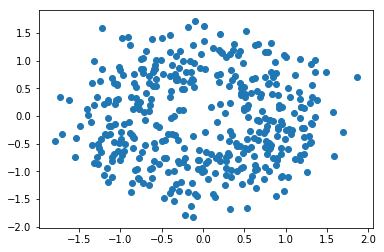

In [7]:
d_ = next(d)
plt.scatter(d_[:,0], d_[:,1])
plt.show()

In [8]:
#first just trying to train on a single gaussian
def traindata_gen1():
    g = GMMsampler(batchSz, n_components=1, weights=[1],
                  mu=[m1], sig=[sig1])
    while(True):
        g.gen_sample()
        yield g.data
d1 = traindata_gen1()

In [62]:
def traindata_genrand():
    while(True):
        g = GMMsampler(batchSz, n_components=1, weights=[1],
                      mu=[scale*np.random.randn(2)], sig=[np.random.rand()*np.eye(2)*scale])
        g.gen_sample()
        yield g.data

d1bar = traindata_genrand()

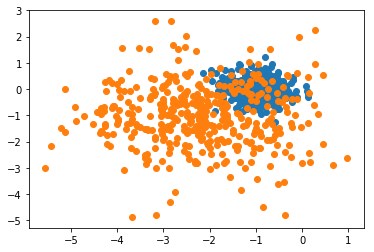

In [84]:
#how does sample trainbatch look
td1 = next(d1)
td1bar = next(d1bar)

plt.figure()
plt.scatter(td1[:,0], td1[:,1])
plt.scatter(td1bar[:,0], td1bar[:,1])
plt.show()

In [11]:
#trying to train
model = GaussNet().cuda()
#diff model
#model = GaussNet1().cuda()

#optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.05)
#trying Adam
optimizer = optim.Adam(model.parameters())

In [12]:
#need to generate both positive and negetive datapoints to train the network
def gettraindata():
    traindata = []
    for i in range(n_posBatch):
        traindata.append((next(d1),np.array([1])))
    for i in range(n_negBatch):
        traindata.append((next(d1bar),np.array([0])))
    np.random.shuffle(traindata)
    return traindata

def gettestdata():
    testdata = []
    for i in range(1):
        testdata.append((next(d1),np.array([1])))
    for i in range(1):
        testdata.append((next(d1bar),np.array([0])))
    np.random.shuffle(testdata)
    return testdata

In [13]:
def plot_loss(losstrack):
    plt.figure()
    plt.plot(losstrack)
    plt.ylabel('loss value')
    plt.xlabel('iterations over various epoch')
    plt.show()

==>>> epoch: 0, batch: 0, train loss: 0.37323483
==>>> epoch: 0, batch: 5, train loss: 0.32289480
==>>> epoch: 0, batch: 10, train loss: 0.65834748
==>>> epoch: 0, batch: 15, train loss: 0.31568076
==>>> epoch: 0, batch: 20, train loss: 0.31569339
==>>> epoch: 0, batch: 25, train loss: 0.31326169
==>>> epoch: 0, batch: 30, train loss: 0.32139988
==>>> epoch: 0, batch: 35, train loss: 0.32658555
==>>> epoch: 0, batch: 40, train loss: 0.32196727
==>>> epoch: 0, batch: 45, train loss: 0.48762257
==>>> epoch: 0, batch: 50, train loss: 0.32025335
==>>> epoch: 0, batch: 55, train loss: 0.61819728
==>>> epoch: 0, batch: 60, train loss: 0.33229485
==>>> epoch: 0, batch: 65, train loss: 0.32077451
==>>> epoch: 0, batch: 70, train loss: 0.32227767
==>>> epoch: 0, batch: 75, train loss: 0.31326169
testing the accuracy of the model right after epoch: 0...
<<<== After epoch: 0, accuracy: 781/800 (97.625%)
==>>> epoch: 1, batch: 0, train loss: 0.34667247
==>>> epoch: 1, batch: 5, train loss: 0.34246

==>>> epoch: 9, batch: 5, train loss: 0.59531893
==>>> epoch: 9, batch: 10, train loss: 0.39415058
==>>> epoch: 9, batch: 15, train loss: 0.32913025
==>>> epoch: 9, batch: 20, train loss: 0.42447738
==>>> epoch: 9, batch: 25, train loss: 0.42888987
==>>> epoch: 9, batch: 30, train loss: 0.35319144
==>>> epoch: 9, batch: 35, train loss: 0.35741945
==>>> epoch: 9, batch: 40, train loss: 0.34664898
==>>> epoch: 9, batch: 45, train loss: 0.33340345
==>>> epoch: 9, batch: 50, train loss: 0.32534998
==>>> epoch: 9, batch: 55, train loss: 0.45343121
==>>> epoch: 9, batch: 60, train loss: 0.32123109
==>>> epoch: 9, batch: 65, train loss: 0.41573411
==>>> epoch: 9, batch: 70, train loss: 0.32964407
==>>> epoch: 9, batch: 75, train loss: 0.32893895
testing the accuracy of the model right after epoch: 9...
<<<== After epoch: 9, accuracy: 696/800 (87.0%)
==>>> epoch: 10, batch: 0, train loss: 0.33201907
==>>> epoch: 10, batch: 5, train loss: 0.61639047
==>>> epoch: 10, batch: 10, train loss: 0.313

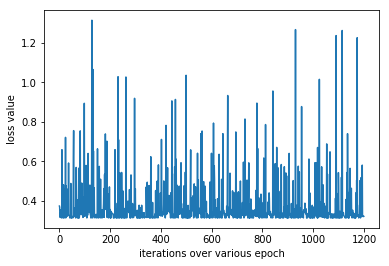

In [86]:
model.double()
n_epoch = 15
losstrack = []
accuracy = []
for eph in range(n_epoch):
    traindata = gettraindata()
    for i in range(n_posBatch+n_negBatch):
        optimizer.zero_grad()
        X,label = traindata[i][0], traindata[i][1]
        X = torch.from_numpy(X)
        X = agd.Variable(X.cuda())
        lbl = [label[0] for i in range(batchSz)]
        lbl = np.array(lbl)
        lbl = torch.LongTensor(lbl)
        lbl = agd.Variable(lbl.cuda())
        outp = model(X)
        loss = F.cross_entropy(outp, lbl)
        loss.backward()
        optimizer.step()
        losstrack.append(loss.data[0])
        if i%5 == 0:
            print('==>>> epoch: {}, batch: {}, train loss: {:.8f}'.format(eph, i, loss.data[0]))
    
    #testing the accuracy of model in this epoch
    print('testing the accuracy of the model right after epoch: {}...'.format(eph))
    testdata = gettestdata()
    correct_cnt = 0
    total_instance = len(testdata)*batchSz
    for i in range(len(testdata)):
        X, label = testdata[i][0], testdata[i][1]
        label = [label[0] for i in range(batchSz)]
        label = np.array(label)
        label = torch.LongTensor(label)
        label = agd.Variable(label.cuda())
        X = torch.from_numpy(X)
        X = agd.Variable(X.cuda())
        outp = model(X)
        pred = outp.data.max(1)[1]
        correct_cnt += pred.eq(label.data).cpu().sum()
    print('<<<== After epoch: {}, accuracy: {}/{} ({}%)'.format(eph, correct_cnt, total_instance, correct_cnt*100/total_instance))
    accuracy.append(correct_cnt*100/total_instance)
plot_loss(losstrack)       

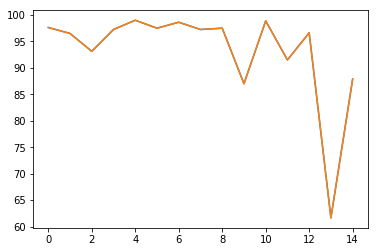

In [88]:
plt.plot(accuracy)
plt.show()

In [15]:
#manually testing on positive and negetive points
tx=next(d1)
tx=torch.from_numpy(tx)
tx = agd.Variable(tx.cuda())
#print(tx)
tou = model(tx)
tou

Variable containing:
 3.9230e-12  1.0000e+00
 1.7434e-13  1.0000e+00
 4.7202e-14  1.0000e+00
 5.3337e-13  1.0000e+00
 1.5435e-15  1.0000e+00
 4.2870e-12  1.0000e+00
 3.2937e-10  1.0000e+00
 5.8852e-11  1.0000e+00
 1.4350e-10  1.0000e+00
 5.4789e-13  1.0000e+00
 5.1887e-15  1.0000e+00
 8.0567e-16  1.0000e+00
 4.5148e-10  1.0000e+00
 7.2050e-16  1.0000e+00
 2.3166e-16  1.0000e+00
 8.4851e-14  1.0000e+00
 2.8372e-15  1.0000e+00
 7.9735e-14  1.0000e+00
 4.7537e-13  1.0000e+00
 2.4910e-10  1.0000e+00
 2.7067e-12  1.0000e+00
 5.7877e-16  1.0000e+00
 2.3340e-10  1.0000e+00
 9.6584e-11  1.0000e+00
 2.7034e-16  1.0000e+00
 3.8957e-11  1.0000e+00
 6.5457e-16  1.0000e+00
 8.7944e-09  1.0000e+00
 2.0242e-16  1.0000e+00
 1.8748e-13  1.0000e+00
 1.6237e-10  1.0000e+00
 1.1033e-09  1.0000e+00
 7.4706e-09  1.0000e+00
 2.8663e-16  1.0000e+00
 4.5879e-14  1.0000e+00
 1.2888e-11  1.0000e+00
 1.1993e-11  1.0000e+00
 1.0150e-15  1.0000e+00
 2.9524e-02  9.7048e-01
 3.4267e-16  1.0000e+00
 3.8828e-15  1.0000

In [16]:
txbar=next(d1bar)
txbar=torch.from_numpy(txbar)
txbar = agd.Variable(txbar.cuda())
#print(tx)
toubar = model(txbar)
toubar

Variable containing:
 1.0000e+00  2.4294e-53
 1.0000e+00  7.7703e-57
 1.0000e+00  5.8801e-56
 1.0000e+00  1.2752e-59
 1.0000e+00  1.1039e-62
 1.0000e+00  5.0884e-57
 1.0000e+00  2.9551e-59
 1.0000e+00  2.1681e-57
 1.0000e+00  1.2460e-54
 1.0000e+00  1.8720e-51
 1.0000e+00  3.9102e-56
 1.0000e+00  1.6755e-58
 1.0000e+00  9.9970e-58
 1.0000e+00  2.0791e-52
 1.0000e+00  1.8866e-56
 1.0000e+00  3.8336e-63
 1.0000e+00  6.4466e-52
 1.0000e+00  7.7421e-51
 1.0000e+00  6.6669e-57
 1.0000e+00  3.3495e-55
 1.0000e+00  1.4538e-54
 1.0000e+00  1.9344e-59
 1.0000e+00  1.5534e-59
 1.0000e+00  2.3098e-59
 1.0000e+00  2.1470e-60
 1.0000e+00  8.0922e-56
 1.0000e+00  1.8466e-47
 1.0000e+00  5.5480e-64
 1.0000e+00  1.3211e-64
 1.0000e+00  2.5881e-54
 1.0000e+00  6.2455e-61
 1.0000e+00  2.0629e-61
 1.0000e+00  4.3959e-61
 1.0000e+00  3.3623e-56
 1.0000e+00  1.2855e-51
 1.0000e+00  7.1553e-57
 1.0000e+00  1.4731e-58
 1.0000e+00  2.8896e-59
 1.0000e+00  3.5815e-50
 1.0000e+00  1.0389e-56
 1.0000e+00  3.4299

In [17]:
model

GaussNet (
  (L1): Linear (2 -> 512)
  (L2): Linear (512 -> 512)
  (L3): Linear (512 -> 512)
  (Ou): Linear (512 -> 2)
)

In [26]:
tou.data.max(1)[1]


 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
